### Phase Plots: FWI vs Extreme Indices

###### Preliminaries:

In [1]:
from matplotlib import pyplot as plt 
import pandas as pd
import xarray
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import sys  
sys.path.insert(0, '/home/theo/scripts/')
import new_fwi
from new_fwi import FWICLASS
from new_fwi import FWI_calc
from cordex_fwi_pe import get_cordex_addresses
from itertools import groupby
import os
import warnings
from matplotlib import ticker
import matplotlib as mpl
import copy

In [2]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
tag = ['01','04','05','06','07','08','09','10','11','12','13','15']

<class 'list'>


#### Building Data

###### TN90p, Percentage of days when TN > 90th percentile:

Let TNij be the daily minimum temperature on day i in period j and let TNin90 be the calendar day 90th percentile centred on a 5-day window for the base period 1961-1990. The percentage of time for the base period is determined where:

TNij > TNin90

To avoid possible inhomogeneity across the in-base and out-base periods, the calculation for the base period (1961-1990) requires the use of a bootstrap processure. Details are described in Zhang et al. (2005) .




###### TX90p, Percentage of days when TX > 90th percentile:

Let TXij be the daily maximum temperature on day i in period j and let TXin90 be the calendar day 90th percentile centred on a 5-day window for the base period 1961-1990. The percentage of time for the base period is determined where:

TXij > TXin90

To avoid possible inhomogeneity across the in-base and out-base periods, the calculation for the base period (1961-1990) requires the use of a bootstrap processure. Details are described in Zhang et al. (2005) .

In [ ]:
# 1) Build arrays of the relavent indices:
    # Drought days
    # Tropical nights (number where T_min > 20C)
    # Number of Summer Days (number where T > 25C)
    # TX90p
    # TN90p
    
# 2) Use code of the below structure to generate 2D phase plots relating FWI/DSR to the above indices

###### Base Functions:

In [ ]:
def get_tasmax_files():
    models = pd.read_csv('/home/theo/cordex_models.txt', sep='\t')

    # Getting file strings:
        # Directories:
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]

        # Filenames:
    #feat. clunky for loops and error handling!
    tasmax_files  = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tasmax_'):
                    tasmax_files.append(str(f_name))


        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))


    for i in range(len(err_indexs)-1,-1,-1):
        del directories[err_indexs[i]]
    
    return directories,tasmax_files

In [ ]:
def get_tasmin_files():
    models = pd.read_csv('/home/theo/cordex_models.txt', sep='\t')

    # Getting file strings:
        # Directories:
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]

        # Filenames:
    #feat. clunky for loops and error handling!
    tasmin_files  = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tasmin_'):
                    tasmin_files.append(str(f_name))


        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))


    for i in range(len(err_indexs)-1,-1,-1):
        del directories[err_indexs[i]]
    
    return directories,tasmin_files

In [163]:
print(len(directories))

49


In [ ]:
def get_summer_inds(in_data):
    # Takes .nc file in
    
    try:
        years  = np.array(pd.to_datetime(np.array(in_data.time)).year)
        months = np.array(pd.to_datetime(np.array(in_data.time)).month)
    except:
        years  = np.vectorize(lambda x: x.year) (np.array(in_data.time))
        months = np.vectorize(lambda x: x.month) (np.array(in_data.time))
    
    yr_inds = np.array([np.where(years == i) for i in range(1981,2081)],dtype=object)
    sum_ind = np.concatenate((np.where(months == 6)[0], np.where(months == 7)[0],
                              np.where(months == 8)[0]),axis = 0)

    indices = np.array([np.intersect1d(yr_inds[i][0],sum_ind) for i in range(100)])
    
    return indices

In [ ]:
def get_mask():
    region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
    region_mask = region_data.admin_region
    region_mask = np.nan_to_num(region_mask)
    mask = (region_mask == 0).astype(float)
    mask = -1*(mask - 1)
    mask[mask == 0] = np.nan 
    return mask

In [166]:
def max_consecutive(line):
    return max(k*sum(1 for i in g) for k,g in groupby(line))

In [167]:
def max_consecutive_array(array):
    ans = np.zeros((128,108))
    for i in range(128):
        for j in range(108):
            ans[i,j] = max_consecutive(array[:,i,j])
    return ans

In [168]:
def max_consecutive_ndarray(array, axis = 0):
    new_shape = list(array.shape)
    new_shape.pop(axis)
    array = array.swapaxes(axis, -1).reshape(-1, array.shape[axis])
    ans = np.zeros(np.prod(array.shape[:-1]))
    for i, v in enumerate(array):

        ans[i] = max_consecutive(v)

    return ans.reshape(new_shape)

###### Building Indices

(12, 100, 128, 108)


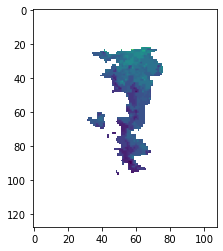

In [182]:
# Consecutive Dry Days (cdd)
# Maximum number of consecutive dry days per time period with daily precipitation amount of less than 1 mm
# 100 x 108 x 128 x 48
def get_cdd(pr_data):
    mask = get_mask()
    rain = np.einsum('ijk,jk->ijk',pr_data.pr[:,:,:,0],mask)
    indices = get_summer_inds(pr_data)
    cdd = np.array([max_consecutive_array(rain[indices[j,:],:,:] < 1) for j in range(100)])
    cdd = np.einsum('ijk,jk->ijk',cdd,mask)
    return cdd

# 1 to 49
out_data = np.array([get_cdd(xarray.open_dataset(f'/data/met/ukcp18/{tag[i]}/dmo/pr_rcp85_ukcp18_natgb_{tag[i]}_day_19801201-20801130.nc',
                                                 engine = "netcdf4")) for i in range(len(tag))])
print(out_data.shape)
plt.imshow(out_data[0,0,:,:])
np.save('/home/theo/outdata/5.outdata/cdd_ukcp',out_data)

In [ ]:
# Consecutive Dry Days (cdd)
# Maximum number of consecutive dry days per time period with daily precipitation amount of less than 1 mm
# 100 x 108 x 128 x 48
def get_cdd(pr_data):
    mask = get_mask()
    rain = np.einsum('ijk,jk->ijk',pr_data.pr*86400,mask)
    indices = get_summer_inds(pr_data)
    cdd = np.array([max_consecutive_array(rain[indices[j,:],:,:] < 1) for j in range(100)])
    cdd = np.einsum('ijk,jk->ijk',cdd,mask)
    return cdd

# 1 to 49
out_data = np.array([get_cdd(xarray.open_dataset(directories[i] + pr_files[i], engine = "netcdf4")) for i in range(1,49)])
print(out_data.shape)
plt.imshow(out_data[0,0,:,:])
np.save('/home/theo/outdata/5.outdata/cdd',out_data)

(12, 100, 128, 108)


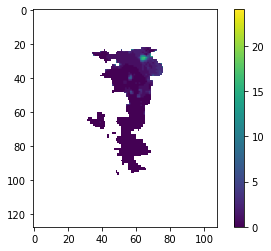

In [214]:
def get_tni(tasmin_data):
    mask = get_mask()
    mint = np.einsum('ijk,jk->ijk',tasmin_data.tasmin[:,:,:,0],mask)
    indices = get_summer_inds(tasmin_data)
    tni = np.array([np.nansum(mint[indices[j,:],:,:] > 20,axis = 0) for j in range(100)])
    tni = np.einsum('ijk,jk->ijk',tni,mask)
    return tni

# 1 to 49: 
out_data = np.array([get_tni(xarray.open_dataset(f'/data/met/ukcp18/{tag[i]}/dmo/tasmin_rcp85_ukcp18_natgb_{tag[i]}_day_19801201-20801130.nc',
                                                 engine = "netcdf4")) for i in range(len(tag))])
print(out_data.shape)
plt.imshow(out_data[0,99,:,:])
plt.colorbar()
np.save('/home/theo/outdata/5.outdata/tni_ukcp',out_data)

In [ ]:
# Tropical nights (number where T_min > 20C)

directories,tasmin_files = get_tasmin_files()

def get_tni(tasmin_data):
    mask = get_mask()
    mint = np.einsum('ijk,jk->ijk',tasmin_data.tasmin - 273.15,mask)
    indices = get_summer_inds(tasmin_data)
    tni = np.array([np.nansum(mint[indices[j,:],:,:] > 20,axis = 0) for j in range(100)])
    tni = np.einsum('ijk,jk->ijk',tni,mask)
    return tni

# 1 to 49: 
out_data = np.array([get_tni(xarray.open_dataset(directories[i] + tasmin_files[i], engine = "netcdf4")) for i in range(1,49)])
print(out_data.shape)
plt.imshow(out_data[12,99,:,:])
plt.colorbar()
np.save('/home/theo/outdata/5.outdata/tni',out_data)

In [ ]:
# Number of Summer Days (number where T > 25C)

def get_nsd(tas_data):
    mask = get_mask()
    temp = np.einsum('ijk,jk->ijk',tas_data.tas[:,:,:,0] - 273.15,mask)
    
    try:
        years  = np.array(pd.to_datetime(np.array(tas_data.time)).year)
    except:
        years  = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
    yr_inds = np.array([np.where(years == i) for i in range(1981,2081)],dtype=object)
    
    indices = get_summer_inds(tas_data)
    nsd = np.array([np.nansum(temp[yr_inds[j][0],:,:] > 25, axis = 0) for j in range(100)])
    nsd = np.einsum('ijk,jk->ijk',nsd,mask)
    return nsd

# 1 to 49:
out_data = np.array([get_nsd(xarray.open_dataset(])
print(out_data.shape)
print(np.unique(out_data)[:30])
plt.imshow(out_data[12,99,:,:])
plt.colorbar()
np.save('/home/theo/outdata/5.outdata/nsd',out_data)

In [ ]:
plt.hist(out_data.flatten(), bins = 70)
plt.xlim(1,20)
plt.ylim(0,125000)

<class 'list'>
(12, 100, 128, 108)


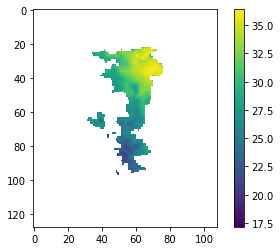

In [215]:
directories,tasmax_files = get_tasmax_files()
# Maximum tasmax in period
def get_txx(tasmax_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mask = get_mask()
        maxt = np.einsum('ijk,jk->ijk',tasmax_data.tasmax[:,:,:,0],mask)
        indices = get_summer_inds(tasmax_data)
        txx = np.array([np.nanmax(maxt[indices[j,:],:,:],axis = 0) for j in range(100)])
        txx = np.einsum('ijk,jk->ijk',txx,mask)
    return txx

# 1 to 49: 
out_data = np.array([get_txx(xarray.open_dataset(f'/data/met/ukcp18/{tag[i]}/dmo/tasmax_rcp85_ukcp18_natgb_{tag[i]}_day_19801201-20801130.nc',
                                                 engine = "netcdf4")) for i in range(len(tag))])
print(out_data.shape)
plt.imshow(out_data[0,99,:,:])
plt.colorbar()
np.save('/home/theo/outdata/5.outdata/txx_ukcp',out_data)

<class 'list'>
(48, 100, 128, 108)


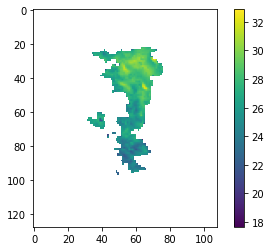

In [19]:
directories,tasmax_files = get_tasmax_files()
# Maximum tasmax in period
def get_txx(tasmax_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mask = get_mask()
        maxt = np.einsum('ijk,jk->ijk',tasmax_data.tasmax - 273.15,mask)
        indices = get_summer_inds(tasmax_data)
        txx = np.array([np.nanmax(maxt[indices[j,:],:,:],axis = 0) for j in range(100)])
        txx = np.einsum('ijk,jk->ijk',txx,mask)
    return txx

# 1 to 49: 
out_data = np.array([get_txx(xarray.open_dataset(directories[i] + tasmax_files[i], engine = "netcdf4")) for i in range(1,49)])
print(out_data.shape)
plt.imshow(out_data[12,99,:,:])
plt.colorbar()
np.save('/home/theo/outdata/5.outdata/txx',out_data)

<class 'list'>
(48, 100, 128, 108)


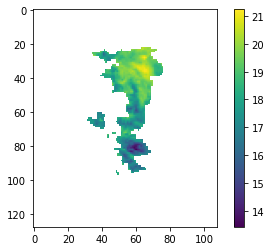

In [20]:
# Maximum tasmin in period
directories,tasmin_files = get_tasmin_files()

def get_tnx(tasmin_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mask = get_mask()
        mint = np.einsum('ijk,jk->ijk',tasmin_data.tasmin - 273.15,mask)
        indices = get_summer_inds(tasmin_data)
        tnx = np.array([np.nanmax(mint[indices[j,:],:,:],axis = 0) for j in range(100)])
        tnx = np.einsum('ijk,jk->ijk',tnx,mask)
    return tnx

# 1 to 49: 
out_data = np.array([get_tnx(xarray.open_dataset(directories[i] + tasmin_files[i], engine = "netcdf4")) for i in range(1,49)])
print(out_data.shape)
plt.imshow(out_data[12,99,:,:])
plt.colorbar()
np.save('/home/theo/outdata/5.outdata/tnx',out_data)

(12, 100, 128, 108)


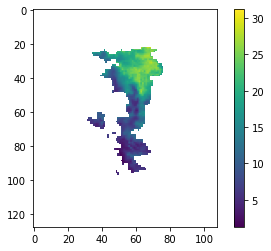

In [188]:
def max_fwi(fwi_data,tas_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mask = get_mask()
        fwi  = np.einsum('ijk,jk->ijk',fwi_data[0,:,:,:],mask)
        indices = get_summer_inds(tas_data)
        fwi_max = np.array([np.nanmax(fwi[indices[j,:],:,:],axis = 0) for j in range(100)])
        fwi_max = np.einsum('ijk,jk->ijk',fwi_max,mask)
    return fwi_max    

out_data = np.array([max_fwi(np.load(f'/data/met/fwi/ukcp18_new_fwi_{tag[i]}.npy'),
                             xarray.open_dataset(f'/data/met/ukcp18/{tag[i]}/dmo/tas_rcp85_ukcp18_natgb_{tag[i]}_day_19801201-20801130.nc',
                                                 engine = "netcdf4")) 
                     for i in range(len(tag))])
np.save('/home/theo/outdata/5.outdata/max_fwi_ukcp',out_data)

print(out_data.shape)
plt.imshow(out_data[0,99,:,:])
plt.colorbar()

<class 'list'>
(48, 100, 128, 108)


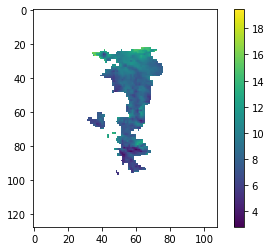

In [24]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()

def max_fwi(fwi_data,tas_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mask = get_mask()
        fwi  = np.einsum('ijk,jk->ijk',fwi_data[0,:,:,:],mask)
        indices = get_summer_inds(tas_data)
        fwi_max = np.array([np.nanmax(fwi[indices[j,:],:,:],axis = 0) for j in range(100)])
        fwi_max = np.einsum('ijk,jk->ijk',fwi_max,mask)
    return fwi_max    

out_data = np.array([max_fwi(np.load(f'/data/met/fwi/ukcordex_new_fwi_{i+1}.npy'),
                             xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")) 
                     for i in range(1,49)])
np.save('/home/theo/outdata/5.outdata/max_fwi',out_data)

print(out_data.shape)
plt.imshow(out_data[12,99,:,:])
plt.colorbar()

<class 'list'>
(48, 100, 128, 108)


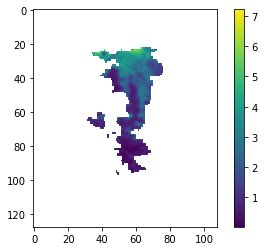

In [25]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()

def med_fwi(fwi_data,tas_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mask = get_mask()
        fwi  = np.einsum('ijk,jk->ijk',fwi_data[0,:,:,:],mask)
        indices = get_summer_inds(tas_data)
        fwi_med = np.array([np.nanmedian(fwi[indices[j,:],:,:],axis = 0) for j in range(100)])
        fwi_med = np.einsum('ijk,jk->ijk',fwi_med,mask)
    return fwi_med    

out_data = np.array([med_fwi(np.load(f'/data/met/fwi/ukcordex_new_fwi_{i+1}.npy'),
                             xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")) 
                     for i in range(1,49)])
np.save('/home/theo/outdata/5.outdata/med_fwi',out_data)

print(out_data.shape)
plt.imshow(out_data[12,99,:,:])
plt.colorbar()

###### Loading data:

In [11]:
cdd = np.load('/home/theo/outdata/5.outdata/cdd.npy')
tni = np.load('/home/theo/outdata/5.outdata/tni.npy')
nsd = np.load('/home/theo/outdata/5.outdata/nsd.npy')
txx = np.load('/home/theo/outdata/5.outdata/txx.npy')
tnx = np.load('/home/theo/outdata/5.outdata/tnx.npy')
fwi_max = np.load('/home/theo/outdata/5.outdata/max_fwi.npy')
fwi_med = np.load('/home/theo/outdata/5.outdata/med_fwi.npy')

In [12]:
print(cdd.shape)
print(tni.shape)
print(nsd.shape)
print(txx.shape)
print(tnx.shape)
print(fwi_max.shape)
print(fwi_med.shape)

(48, 100, 128, 108)
(48, 100, 128, 108)
(48, 100, 128, 108)
(48, 100, 128, 108)
(48, 100, 128, 108)
(48, 100, 128, 108)
(48, 100, 128, 108)


In [5]:
cdd_flat = cdd.flatten()
tni_flat = tni.flatten()
nsd_flat = nsd.flatten()
txx_flat = txx.flatten()
tnx_flat = tnx.flatten()



fwi_max_flat = fwi_max.flatten()
fwi_med_flat = fwi_med.flatten()
dsr_max_flat = (0.0272*fwi_max**1.77).flatten()
dsr_med_flat = (0.0272*fwi_med**1.77).flatten()



###### Building 2D Histograms:

In [6]:
print(np.nanmin(cdd),np.nanmax(cdd))
print(np.nanmin(tni),np.nanmax(tni))
print(np.nanmin(nsd),np.nanmax(nsd))
print(np.nanmin(txx),np.nanmax(txx))
print(np.nanmin(tnx),np.nanmax(tnx))
print(np.nanmin(fwi_max),np.nanmax(fwi_max))
print(np.nanmin(fwi_med),np.nanmax(fwi_med))

0.0 90.0
0.0 79.0
0.0 73.0
12.132232666015625 47.945220947265625
6.56298828125 33.599029541015625
0.00271425571325217 108.82133457909669
6.609535931941611e-07 30.086278721571812


In [7]:
cdd_fwimax, cdd_fwimax_xs, cdd_fwimax_ys = np.histogram2d(cdd_flat, fwi_max_flat, bins = [20,200], 
                                    range = [[np.nanmin(cdd),np.nanmax(cdd)],
                                             [np.nanmin(fwi_max),np.nanmax(fwi_max)]])
cdd_fwimed, cdd_fwimed_xs, cdd_fwimed_ys = np.histogram2d(cdd_flat, fwi_med_flat, bins = [20,200], 
                                    range = [[np.nanmin(cdd),np.nanmax(cdd)],
                                             [np.nanmin(fwi_med),np.nanmax(fwi_med)]])
cdd_dsrmax, cdd_dsrmax_xs, cdd_dsrmax_ys = np.histogram2d(cdd_flat, dsr_max_flat, bins = [20,200], 
                                    range = [[np.nanmin(cdd),np.nanmax(cdd)],
                                             [np.nanmin(dsr_max_flat),np.nanmax(dsr_max_flat)]])
cdd_dsrmed, cdd_dsrmed_xs, cdd_dsrmed_ys = np.histogram2d(cdd_flat, dsr_med_flat, bins = [20,200], 
                                    range = [[np.nanmin(cdd),np.nanmax(cdd)],
                                             [np.nanmin(dsr_med_flat),np.nanmax(dsr_med_flat)]])


tni_fwimax, tni_fwimax_xs, tni_fwimax_ys = np.histogram2d(tni_flat, fwi_max_flat, bins = [40,100], 
                                    range = [[np.nanmin(tni),np.nanmax(tni)],
                                             [np.nanmin(fwi_max),np.nanmax(fwi_max)]])
tni_fwimed, tni_fwimed_xs, tni_fwimed_ys = np.histogram2d(tni_flat, fwi_med_flat, bins = [40,100], 
                                    range = [[np.nanmin(tni),np.nanmax(tni)],
                                             [np.nanmin(fwi_med),np.nanmax(fwi_med)]])
tni_dsrmax, tni_dsrmax_xs, tni_dsrmax_ys = np.histogram2d(tni_flat, dsr_max_flat, bins = [40,100], 
                                    range = [[np.nanmin(tni),np.nanmax(tni)],
                                             [np.nanmin(dsr_max_flat),np.nanmax(dsr_max_flat)]])
tni_dsrmed, tni_dsrmed_xs, tni_dsrmed_ys = np.histogram2d(tni_flat, dsr_med_flat, bins = [40,100], 
                                    range = [[np.nanmin(tni),np.nanmax(tni)],
                                             [np.nanmin(dsr_med_flat),np.nanmax(dsr_med_flat)]])


nsd_fwimax, nsd_fwimax_xs, nsd_fwimax_ys = np.histogram2d(nsd_flat, fwi_max_flat, bins = [35,100], 
                                    range = [[np.nanmin(nsd),np.nanmax(nsd)],
                                             [np.nanmin(fwi_max),np.nanmax(fwi_max)]])
nsd_fwimed, nsd_fwimed_xs, nsd_fwimed_ys = np.histogram2d(cdd_flat, fwi_med_flat, bins = [35,100], 
                                    range = [[np.nanmin(nsd),np.nanmax(nsd)],
                                             [np.nanmin(fwi_med),np.nanmax(fwi_med)]])
nsd_dsrmax, nsd_dsrmax_xs, nsd_dsrmax_ys = np.histogram2d(cdd_flat, dsr_max_flat, bins = [35,100], 
                                    range = [[np.nanmin(nsd),np.nanmax(nsd)],
                                             [np.nanmin(dsr_max_flat),np.nanmax(dsr_max_flat)]])
nsd_dsrmed, nsd_dsrmed_xs, nsd_dsrmed_ys = np.histogram2d(cdd_flat, dsr_med_flat, bins = [35,100], 
                                    range = [[np.nanmin(nsd),np.nanmax(nsd)],
                                             [np.nanmin(dsr_med_flat),np.nanmax(dsr_med_flat)]])


txx_fwimax, txx_fwimax_xs, txx_fwimax_ys = np.histogram2d(txx_flat, fwi_max_flat, bins = [200,200], 
                                    range = [[np.nanmin(txx),np.nanmax(txx)],
                                             [np.nanmin(fwi_max),np.nanmax(fwi_max)]])
txx_fwimed, txx_fwimed_xs, txx_fwimed_ys = np.histogram2d(txx_flat, fwi_med_flat, bins = [200,200], 
                                    range = [[np.nanmin(txx),np.nanmax(txx)],
                                             [np.nanmin(fwi_med),np.nanmax(fwi_med)]])
txx_dsrmax, txx_dsrmax_xs, txx_dsrmax_ys = np.histogram2d(txx_flat, dsr_max_flat, bins = [200,200], 
                                    range = [[np.nanmin(txx),np.nanmax(txx)],
                                             [np.nanmin(dsr_max_flat),np.nanmax(dsr_max_flat)]])
txx_dsrmed, txx_dsrmed_xs, txx_dsrmed_ys = np.histogram2d(txx_flat, dsr_med_flat, bins = [200,200], 
                                    range = [[np.nanmin(txx),np.nanmax(txx)],
                                             [np.nanmin(dsr_med_flat),np.nanmax(dsr_med_flat)]])


tnx_fwimax, tnx_fwimax_xs, tnx_fwimax_ys = np.histogram2d(tnx_flat, fwi_max_flat, bins = [200,200], 
                                    range = [[np.nanmin(tnx),np.nanmax(tnx)],
                                             [np.nanmin(fwi_max),np.nanmax(fwi_max)]])
tnx_fwimed, tnx_fwimed_xs, tnx_fwimed_ys = np.histogram2d(tnx_flat, fwi_med_flat, bins = [200,200], 
                                    range = [[np.nanmin(tnx),np.nanmax(tnx)],
                                             [np.nanmin(fwi_med),np.nanmax(fwi_med)]])
tnx_dsrmax, tnx_dsrmax_xs, tnx_dsrmax_ys = np.histogram2d(tnx_flat, dsr_max_flat, bins = [200,200], 
                                    range = [[np.nanmin(tnx),np.nanmax(tnx)],
                                             [np.nanmin(dsr_max_flat),np.nanmax(dsr_max_flat)]])
tnx_dsrmed, tnx_dsrmed_xs, tnx_dsrmed_ys = np.histogram2d(tnx_flat, dsr_med_flat, bins = [200,200], 
                                    range = [[np.nanmin(tnx),np.nanmax(tnx)],
                                             [np.nanmin(dsr_med_flat),np.nanmax(dsr_med_flat)]])

In [8]:
index_codes  = ['Maximum CDD in Summer',
                'Number of Tropical Nights in Summer',
                'Number of Summer Days in Year',
                'Maximum Temperature in Summer',
                'Maximum Daily Minimum Temperature in Summer']
fire_codes   = ['Maximum FWI','Median FWI','Maximum DSR','Median DSR']

To do: 
- Code Axis labels so not just bin number but the actual value...

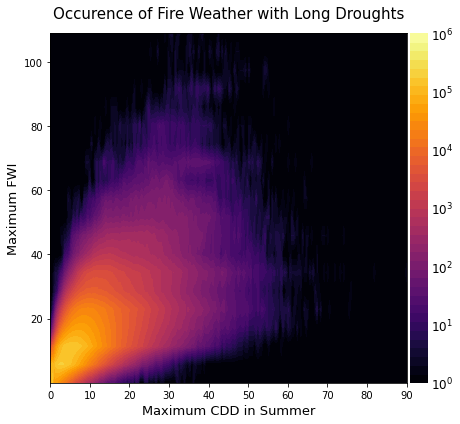

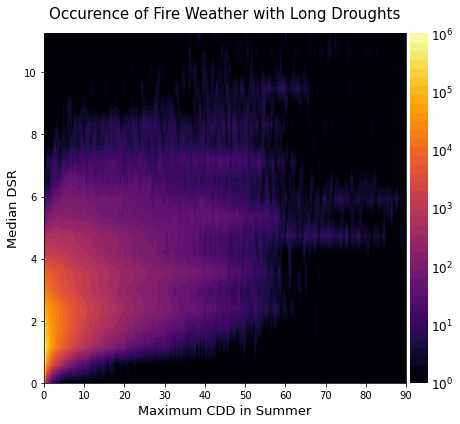

In [9]:
fig,ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6.5)
levels = np.linspace(0, 6, 40+1)
ax.set_title(f'Occurence of Fire Weather with Long Droughts',fontsize=15,pad=15)
ax.set_xlabel(index_codes[0],fontsize=13)
ax.set_ylabel(fire_codes[0],fontsize=13)
ax.set_xlim(np.nanmin(cdd_flat),np.nanmax(cdd_flat))  
ax.set_ylim(np.nanmin(fwi_max_flat),np.nanmax(fwi_max_flat))
image = ax.contourf(np.log10(cdd_fwimax+1),cmap=plt.get_cmap('inferno'),levels=levels,
                   extent = (cdd_fwimax_xs[0], cdd_fwimax_xs[-1], cdd_fwimax_ys[0], cdd_fwimax_ys[-1]))
#ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/CDDxFWImax')



fig,ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6.5)
levels = np.linspace(0, 6, 40+1)
ax.set_title(f'Occurence of Fire Weather with Long Droughts',fontsize=15,pad=15)
ax.set_xlabel(index_codes[0],fontsize=13)
ax.set_ylabel(fire_codes[3],fontsize=13)
ax.set_xlim(np.nanmin(cdd_flat),np.nanmax(cdd_flat))  
ax.set_ylim(np.nanmin(dsr_med_flat),np.nanmax(dsr_med_flat))
image = ax.contourf(np.log10(cdd_dsrmed+1),cmap=plt.get_cmap('inferno'),levels=levels,
                   extent = (cdd_dsrmed_xs[0], cdd_dsrmed_xs[-1], cdd_dsrmed_ys[0], cdd_dsrmed_ys[-1]))
#ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/CDDxDSRmed')

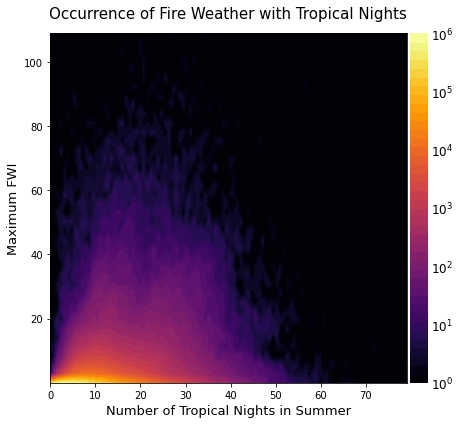

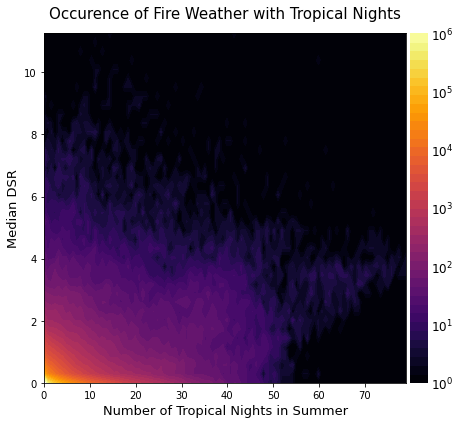

In [10]:
fig,ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6.5)
levels = np.linspace(0, 6, 40+1)
ax.set_title(f'Occurrence of Fire Weather with Tropical Nights',fontsize=15,pad=15)

ax.set_xlabel(index_codes[1],fontsize=13)
ax.set_ylabel(fire_codes[0],fontsize=13)
ax.set_xlim(np.nanmin(tni_flat),np.nanmax(tni_flat))  
ax.set_ylim(np.nanmin(fwi_max_flat),np.nanmax(fwi_max_flat))
image = ax.contourf(np.log10(tni_fwimax+1),cmap=plt.get_cmap('inferno'),levels=levels,
                   extent = (tni_fwimax_xs[0], tni_fwimax_xs[-1], tni_fwimax_ys[0], tni_fwimax_ys[-1]))

#ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/TNIxFWImax')



fig,ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6.5)
levels = np.linspace(0, 6, 40+1)
ax.set_title(f'Occurence of Fire Weather with Tropical Nights',fontsize=15,pad=15)

ax.set_xlabel(index_codes[1],fontsize=13)
ax.set_ylabel(fire_codes[3],fontsize=13)
ax.set_xlim(np.nanmin(tni_flat),np.nanmax(tni_flat))  
ax.set_ylim(np.nanmin(dsr_med_flat),np.nanmax(dsr_med_flat))
image = ax.contourf(np.log10(tni_dsrmed+1),cmap=plt.get_cmap('inferno'),levels=levels,
                   extent = (tni_dsrmed_xs[0], tni_dsrmed_xs[-1], tni_dsrmed_ys[0], tni_dsrmed_ys[-1]))

#ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/TNIxDSRmed')

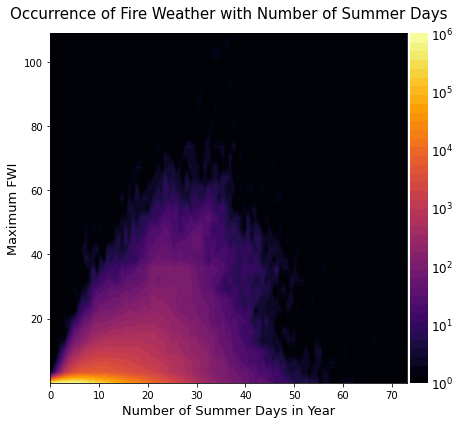

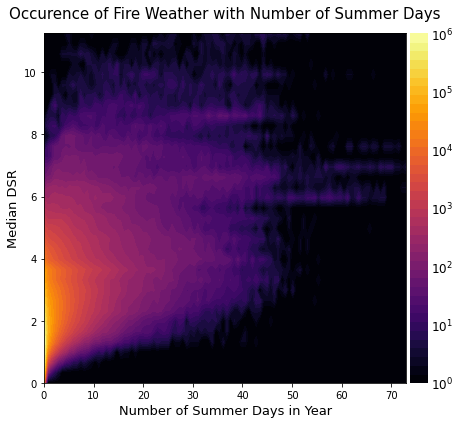

In [11]:
fig,ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6.5)
levels = np.linspace(0, 6, 40+1)
ax.set_title(f'Occurrence of Fire Weather with Number of Summer Days',fontsize=15,pad=15)

ax.set_xlabel(index_codes[2],fontsize=13)
ax.set_ylabel(fire_codes[0],fontsize=13)
ax.set_xlim(np.nanmin(nsd_flat),np.nanmax(nsd_flat))  
ax.set_ylim(np.nanmin(fwi_max_flat),np.nanmax(fwi_max_flat))
image = ax.contourf(np.log10(nsd_fwimax+1),cmap=plt.get_cmap('inferno'),levels=levels,
                   extent = (nsd_fwimax_xs[0], nsd_fwimax_xs[-1], nsd_fwimax_ys[0], nsd_fwimax_ys[-1]))

#ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/NSDxFWImax')



fig,ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6.5)
levels = np.linspace(0, 6, 40+1)
ax.set_title(f'Occurence of Fire Weather with Number of Summer Days',fontsize=15,pad=15)

ax.set_xlabel(index_codes[2],fontsize=13)
ax.set_ylabel(fire_codes[3],fontsize=13)
ax.set_xlim(np.nanmin(nsd_flat),np.nanmax(nsd_flat))  
ax.set_ylim(np.nanmin(dsr_med_flat),np.nanmax(dsr_med_flat))
image = ax.contourf(np.log10(nsd_dsrmed+1),cmap=plt.get_cmap('inferno'),levels=levels,
                   extent = (nsd_dsrmed_xs[0],nsd_dsrmed_xs[-1],nsd_dsrmed_ys[0],nsd_dsrmed_ys[-1]))

#ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/NSDxDSRmed')

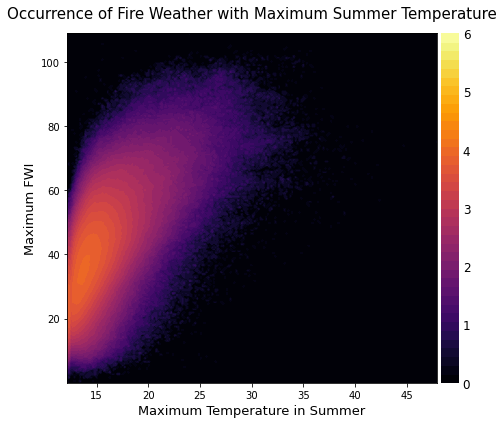

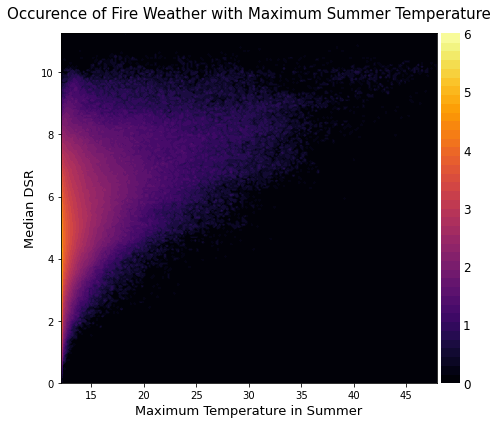

In [29]:
fig,ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6.5)
levels = np.linspace(0, 6, 40+1)
ax.set_title(f'Occurrence of Fire Weather with Maximum Summer Temperature',fontsize=15,pad=15)

ax.set_xlabel(index_codes[3],fontsize=13)
ax.set_ylabel(fire_codes[0],fontsize=13)
ax.set_xlim(np.nanmin(txx_flat),np.nanmax(txx_flat))  
ax.set_ylim(np.nanmin(fwi_max_flat),np.nanmax(fwi_max_flat))
image = ax.contourf(np.log10(txx_fwimax+1),cmap=plt.get_cmap('inferno'),levels=levels,
                   extent = (txx_fwimax_xs[0],txx_fwimax_xs[-1],txx_fwimax_ys[0],txx_fwimax_ys[-1]))

#ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/TXXxFWImax')



fig,ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6.5)
levels = np.linspace(0, 6, 40+1)
ax.set_title(f'Occurence of Fire Weather with Maximum Summer Temperature',fontsize=15,pad=15)

ax.set_xlabel(index_codes[3],fontsize=13)
ax.set_ylabel(fire_codes[3],fontsize=13)
ax.set_xlim(np.nanmin(txx_flat),np.nanmax(txx_flat))  
ax.set_ylim(np.nanmin(dsr_med_flat),np.nanmax(dsr_med_flat))
image = ax.contourf(np.log10(txx_dsrmed+1),cmap=plt.get_cmap('inferno'),levels=levels,
                   extent = (txx_dsrmed_xs[0],txx_dsrmed_xs[-1],txx_dsrmed_ys[0],txx_dsrmed_ys[-1]))

#ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/TXXxDSRmed')

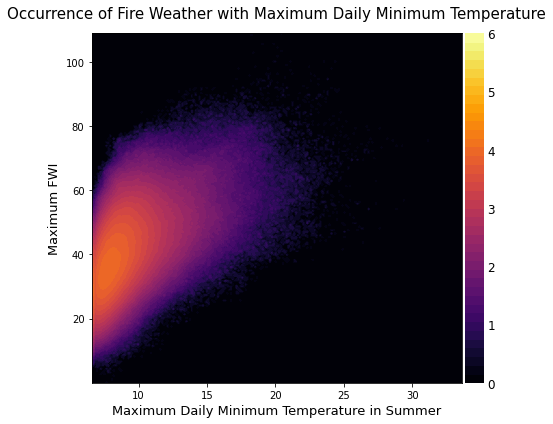

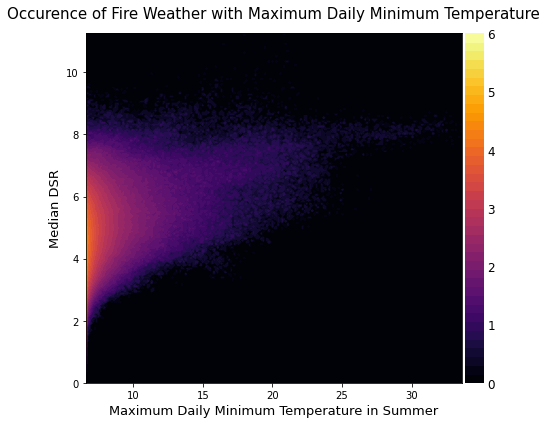

In [30]:
fig,ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6.5)
levels = np.linspace(0, 6, 40+1)
ax.set_title(f'Occurrence of Fire Weather with Maximum Daily Minimum Temperature',fontsize=15,pad=15)

ax.set_xlabel(index_codes[4],fontsize=13)
ax.set_ylabel(fire_codes[0],fontsize=13)
ax.set_xlim(np.nanmin(tnx_flat),np.nanmax(tnx_flat))  
ax.set_ylim(np.nanmin(fwi_max_flat),np.nanmax(fwi_max_flat))
image = ax.contourf(np.log10(tnx_fwimax+1),cmap=plt.get_cmap('inferno'),levels=levels,
                   extent = (tnx_fwimax_xs[0],tnx_fwimax_xs[-1],tnx_fwimax_ys[0],tnx_fwimax_ys[-1]))

#ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)
cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/TNXxFWImax')



fig,ax = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6.5)
levels = np.linspace(0, 6, 40+1)
ax.set_title(f'Occurence of Fire Weather with Maximum Daily Minimum Temperature',fontsize=15,pad=15)

ax.set_xlabel(index_codes[4],fontsize=13)
ax.set_ylabel(fire_codes[3],fontsize=13)
ax.set_xlim(np.nanmin(tnx_flat),np.nanmax(tnx_flat))  
ax.set_ylim(np.nanmin(dsr_med_flat),np.nanmax(dsr_med_flat))
image = ax.contourf(np.log10(tnx_dsrmed+1),cmap=plt.get_cmap('inferno'),levels=levels,
                   extent = (tnx_dsrmed_xs[0],tnx_dsrmed_xs[-1],tnx_dsrmed_ys[0],tnx_dsrmed_ys[-1]))

#ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)
cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$'))
plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/TNXxDSRmed')

#### Actual Usefulest Outputs:

###### Preliminaries

In [1]:
from matplotlib import pyplot as plt 
import pandas as pd
import xarray
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import sys  
sys.path.insert(0, '/home/theo/scripts/')
import new_fwi
from new_fwi import FWICLASS
from new_fwi import FWI_calc
from cordex_fwi_pe import get_cordex_addresses
from itertools import groupby
import os
import warnings
from matplotlib import ticker

###### Building Grid-cell area arrays:

In [2]:
def get_lat_lon_ukcp(grid_lat,grid_lon):
    rlon = grid_lon * np.pi/180
    rlat = grid_lat * np.pi/180
    
    theta = -(90 - 39.25) * np.pi/180
    phi = -(180 - 162) * np.pi/180
    x = np.outer(np.cos(rlat),np.cos(rlon))
    y = np.outer(np.cos(rlat),np.sin(rlon))
    z = np.outer(np.sin(rlat),np.ones(len(rlon)))

    x_new = np.cos(theta) * np.cos(phi) * x + np.sin(phi) * y + np.sin(theta) * np.cos(phi) * z
    y_new = -np.cos(theta) * np.sin(phi) * x + np.cos(phi) * y - np.sin(theta) * np.sin(phi) * z
    z_new = -np.sin(theta) * x + np.cos(theta) * z
    
    lons = np.arctan(np.divide(y_new, x_new)) * 180/np.pi
    lats = np.arcsin(z_new) * 180/np.pi
    
    return lons,lats


def earth_radius(lat):
    # From: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    lat = np.deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    return r


def area_grid(lats,lons):
    # Adapted rom: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    R = earth_radius(lats)
    dlat = np.deg2rad(np.gradient(lats, axis=0))
    dlon = np.deg2rad(np.gradient(lons, axis=1))
    dy = dlat * R
    dx = dlon * R * np.cos(np.deg2rad(lats))
    area_weights = dy * dx
    
    return area_weights

In [3]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
mask = np.logical_not((region_mask == 0)).astype(int)

<class 'list'>
(48, 128, 108)


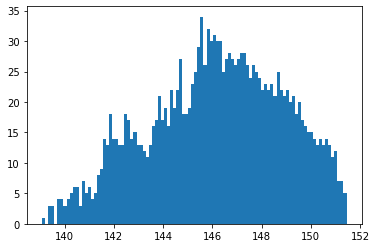

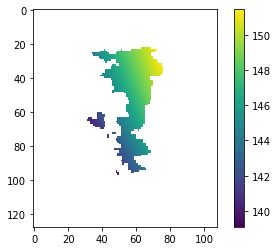

In [103]:
# EuroCORDEX:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
def cordex_area(directory,tas_file):
    try:
        tas_data_a  = xarray.open_dataset(directory + tas_file, engine = "netcdf4")
        lats = np.array(tas_data_a.latitude)
        lons = np.array(tas_data_a.longitude)
    except:
        tas_data_a  = xarray.open_dataset(directory + tas_file, engine = "netcdf4")
        lats = np.array(tas_data_a.lat)
        lons = np.array(tas_data_a.lon)
    w = mask * area_grid(lats,lons) # Weightings
    w[w==0] = np.nan
    w = 242495 * w / np.nansum(w)
    w[w < 100] = np.nan
    w = 242495 * w / np.nansum(w)
    return w

area_cord = np.array([cordex_area(directories[i],tas_files[i]) for i in range(1,len(directories))])

print(area_cord.shape)

plot = area_cord[0,:,:]

plt.figure()
plt.hist(plot.flatten(),bins=100)
plt.figure()
plt.imshow(plot)
plt.colorbar()

# 242,495 km2 (Total area of great Britain and Northern Ireland)

In [114]:
cord_weights = np.array([area_cord for i in range(20)])
cord_weights = np.swapaxes(cord_weights,1,0)/(48*20)
print(cord_weights.shape)

(48, 20, 128, 108)


(12, 128, 108)


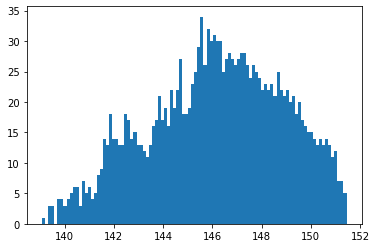

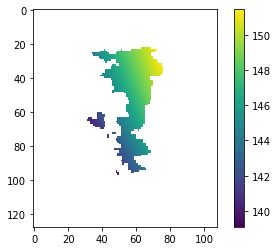

In [102]:
# UKCP18:
tag = ['01','04','05','06','07','08','09','10','11','12','13','15']
tas_files = [f'/data/met/ukcp18/{tag[k]}/dmo/tas_rcp85_ukcp18_natgb_{tag[k]}_day_19801201-20801130.nc' for k in range(len(tag))]
tas_data  = [xarray.open_dataset(tas_files[k], engine = "netcdf4") for k in range(len(tas_files))]

def ukcp18_area(tas_data):
    try:
        lats = np.array(tas_data.latitude)
        lons = np.array(tas_data.longitude)
    except:
        lats = np.array(tas_data.lat)
        lons = np.array(tas_data.lon)
    lons = np.where(lons < 180, lons, lons-360)

    w = mask * area_grid(lats,lons) # Weightings
    w[w==0] = np.nan
    w = 242495 * w / np.nansum(w)
    w[w < 100] = np.nan
    w = 242495 * w / np.nansum(w)
    return w

area_ukcp = np.array([ukcp18_area(xarray.open_dataset(tas_files[i], engine = "netcdf4")) for i in range(len(tag))])

print(area_ukcp.shape)

plot = area_ukcp[0,:,:]

plt.figure()
plt.hist(plot.flatten(),bins=100)
plt.figure()
plt.imshow(plot)
plt.colorbar()

In [113]:
ukcp_weights = np.array([area_ukcp for i in range(20)])
ukcp_weights = np.swapaxes(ukcp_weights,1,0)/(48*20)
print(ukcp_weights.shape)

(12, 20, 128, 108)


###### Making Plots:

In [203]:
index_codes  = ['Maximum CDD in Summer',
                'Number of Tropical Nights in Summer',
                'Number of Summer Days in Year',
                'Maximum Summer Temperature']
fire_codes   = ['Maximum FWI','Median FWI','Maximum DSR','Median DSR']

In [116]:
cdd = np.load('/home/theo/outdata/5.outdata/cdd.npy')
print(cdd[:,80:100,:,:].shape)
print(cdd[:,0:20,:,:].shape)
print(cord_weights.shape)
print(np.nansum(cord_weights))

(48, 20, 128, 108)
(48, 20, 128, 108)
(48, 20, 128, 108)
242495.0000000015


In [137]:
# Loading Data:
cdd = np.load('/home/theo/outdata/5.outdata/cdd.npy')
tni = np.load('/home/theo/outdata/5.outdata/tni.npy')
nsd = np.load('/home/theo/outdata/5.outdata/nsd.npy')
txx = np.load('/home/theo/outdata/5.outdata/txx.npy')
tnx = np.load('/home/theo/outdata/5.outdata/tnx.npy')
fwi_max = np.load('/home/theo/outdata/5.outdata/max_fwi.npy')
fwi_med = np.load('/home/theo/outdata/5.outdata/med_fwi.npy')


cdd_beg_flat = cdd[:,0:20,:,:].flatten()
tni_beg_flat = tni[:,0:20,:,:].flatten()
nsd_beg_flat = nsd[:,0:20,:,:].flatten()
txx_beg_flat = txx[:,0:20,:,:].flatten()
tnx_beg_flat = tnx[:,0:20,:,:].flatten()


fwi_max_beg_flat = fwi_max[:,0:20,:,:].flatten()
fwi_med_beg_flat = fwi_med[:,0:20,:,:].flatten()
dsr_max_beg_flat = (0.0272*fwi_max[:,0:20,:,:]**1.77).flatten()
dsr_med_beg_flat = (0.0272*fwi_med[:,0:20,:,:]**1.77).flatten()


cdd_end_flat = cdd[:,80:100,:,:].flatten()
tni_end_flat = tni[:,80:100,:,:].flatten()
nsd_end_flat = nsd[:,80:100,:,:].flatten()
txx_end_flat = txx[:,80:100,:,:].flatten()
tnx_end_flat = tnx[:,80:100,:,:].flatten()


fwi_max_end_flat = fwi_max[:,80:100,:,:].flatten()
fwi_med_end_flat = fwi_med[:,80:100,:,:].flatten()
dsr_max_end_flat = (0.0272*fwi_max[:,80:100,:,:]**1.77).flatten()
dsr_med_end_flat = (0.0272*fwi_med[:,80:100,:,:]**1.77).flatten()

#weights = cord_weights.flatten()

In [177]:
print([[np.nanmin(cdd),np.nanmax(cdd)],[np.nanmin(fwi_max),np.nanmax(fwi_max)]])

[[0.0, 90.0], [0.00271425571325217, 108.82133457909669]]


In [206]:
cdd_fwimax_beg, cdd_fwimax_xs, cdd_fwimax_ys = np.histogram2d(cdd_beg_flat, 
                                                              fwi_max_beg_flat,
                                                              normed = False,
                                                              bins = [20,20], 
                                                              range = [[0,90],
                                                                       [0,110]])
cdd_fwimax_end, cdd_fwimax_xs, cdd_fwimax_ys = np.histogram2d(cdd_end_flat, 
                                                              fwi_max_end_flat,
                                                              normed = False,
                                                              bins = [20,20], 
                                                              range = [[0,90],
                                                                       [0,110]])
txx_fwimax_beg, txx_fwimax_xs, txx_fwimax_ys = np.histogram2d(txx_beg_flat, 
                                                              fwi_max_beg_flat,
                                                              normed = False,
                                                              bins = [20,20], 
                                                              range = [[10,45],
                                                                       [0,110]])
txx_fwimax_end, txx_fwimax_xs, txx_fwimax_ys = np.histogram2d(txx_end_flat, 
                                                              fwi_max_end_flat,
                                                              normed = False,
                                                              bins = [20,20], 
                                                              range = [[10,45],
                                                                       [0,110]])
tni_fwimax_beg, tni_fwimax_xs, tni_fwimax_ys = np.histogram2d(tni_beg_flat, 
                                                              fwi_max_beg_flat,
                                                              normed = False,
                                                              bins = [20,20], 
                                                              range = [[0,80],
                                                                       [0,110]])
tni_fwimax_end, tni_fwimax_xs, tni_fwimax_ys = np.histogram2d(tni_end_flat, 
                                                              fwi_max_end_flat,
                                                              normed = False,
                                                              bins = [20,20], 
                                                              range = [[0,80],
                                                                       [0,110]])
#                                                          weights = weights)
cdd_fwimax_beg = 242495 * (cdd_fwimax_beg)/(0.12000868055555555*48*20*108*128)
cdd_fwimax_end = 242495 * (cdd_fwimax_end)/(0.12000868055555555*48*20*108*128)
txx_fwimax_beg = 242495 * (txx_fwimax_beg)/(0.12000868055555555*48*20*108*128)
txx_fwimax_end = 242495 * (txx_fwimax_end)/(0.12000868055555555*48*20*108*128)
tni_fwimax_beg = 242495 * (txx_fwimax_beg)/(0.12000868055555555*48*20*108*128)
tni_fwimax_end = 242495 * (txx_fwimax_end)/(0.12000868055555555*48*20*108*128)

In [192]:
print(np.nanmax(np.log10(cdd_fwimax_end+1)))
print(np.nanmax(np.log10(cdd_fwimax_beg+1)))
print(np.nanmax(np.log10(txx_fwimax_end+1)))
print(np.nanmax(np.log10(txx_fwimax_beg+1)))

4.638769805141137
4.657147518055635
4.29328787475337
4.314282627244543


In [181]:
extent = (cdd_fwimax_xs[0], cdd_fwimax_xs[-1], cdd_fwimax_ys[0], cdd_fwimax_ys[-1])
print(extent)

(0.0, 90.0, 0.0, 110.0)


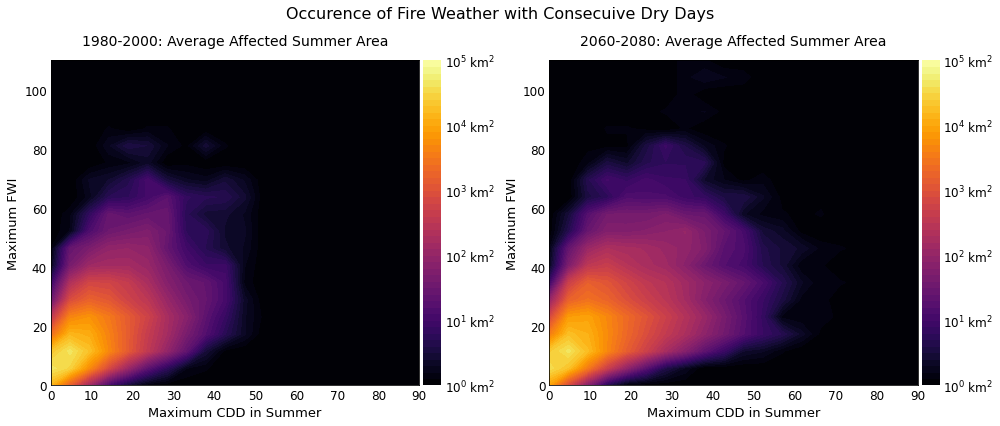

In [202]:
fig,ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(14)

levels = np.linspace(0, 5, 50+1)

fig.suptitle('Occurence of Fire Weather with Consecuive Dry Days',fontsize=16)

ax[0].set_title(f'1980-2000: Average Affected Summer Area',fontsize=14,pad=15)
ax[0].set_xlabel(index_codes[0],fontsize=13)
ax[0].set_ylabel(fire_codes[0],fontsize=13)
ax[0].set_xlim(0,90)  
ax[0].set_ylim(0,110)
ax[0].tick_params(length=0,labelsize=12)
image = ax[0].contourf(np.log10(cdd_fwimax_beg+1),cmap=plt.get_cmap('inferno'),levels=levels,
                       extent = (0.0, 90.0, 0.0, 110.0))

divider = make_axes_locatable(ax[0])
cx = divider.append_axes('right', size='5%', pad=0.05)
cbr = fig.colorbar(image, cax=cx, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbr.locator = tick_locator
cbr.update_ticks()
cbr.outline.set_visible(False)
cbr.ax.tick_params(length=0,labelsize=12)

cbr.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$ km$^2$'))



ax[1].set_title(f'2060-2080: Average Affected Summer Area',fontsize=14,pad=15)
ax[1].set_xlabel(index_codes[0],fontsize=13)
ax[1].set_ylabel(fire_codes[0],fontsize=13)
ax[1].set_xlim(0,90)  
ax[1].set_ylim(0,110)
ax[1].tick_params(length=0,labelsize=12)
image = ax[1].contourf(np.log10(cdd_fwimax_end+1),cmap=plt.get_cmap('inferno'),levels=levels,
                       extent = (0.0, 90.0, 0.0, 110.0))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)

cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$ km$^2$'))

plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/CDDxFWImax')

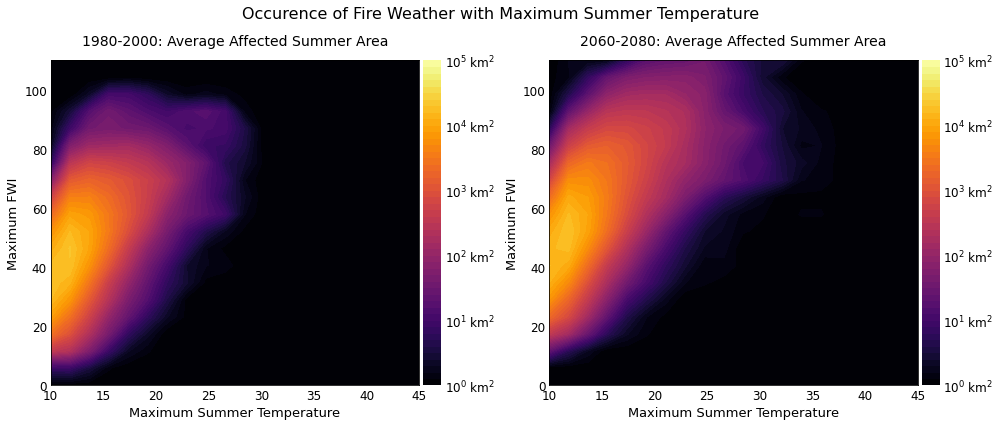

In [205]:
fig,ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(14)

levels = np.linspace(0, 5, 50+1)

fig.suptitle('Occurence of Fire Weather with Maximum Summer Temperature',fontsize=16)

ax[0].set_title(f'1980-2000: Average Affected Summer Area',fontsize=14,pad=15)
ax[0].set_xlabel(index_codes[3],fontsize=13)
ax[0].set_ylabel(fire_codes[0],fontsize=13)
ax[0].set_xlim(10,45)  
ax[0].set_ylim(0,110)
ax[0].tick_params(length=0,labelsize=12)
image = ax[0].contourf(np.log10(txx_fwimax_beg+1),cmap=plt.get_cmap('inferno'),levels=levels,
                       extent = (10.0, 45.0, 0.0, 110.0))

divider = make_axes_locatable(ax[0])
cx = divider.append_axes('right', size='5%', pad=0.05)
cbr = fig.colorbar(image, cax=cx, orientation='vertical',ticks=[0,10,100,1000,10000])
tick_locator = ticker.MaxNLocator(nbins=6)
cbr.locator = tick_locator
cbr.update_ticks()
cbr.outline.set_visible(False)
cbr.ax.tick_params(length=0,labelsize=12)

cbr.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$ km$^2$'))



ax[1].set_title(f'2060-2080: Average Affected Summer Area',fontsize=14,pad=15)
ax[1].set_xlabel(index_codes[3],fontsize=13)
ax[1].set_ylabel(fire_codes[0],fontsize=13)
ax[1].set_xlim(10,45)  
ax[1].set_ylim(0,110)
ax[1].tick_params(length=0,labelsize=12)
image = ax[1].contourf(np.log10(txx_fwimax_end+1),cmap=plt.get_cmap('inferno'),levels=levels,
                       extent = (10.0, 45.0, 0.0, 110.0))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical',ticks=[0,10,100,1000,10000])
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)

cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$ km$^2$'))

plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/TXXxFWImax')

In [ ]:
fig,ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(14)

levels = np.linspace(0, 5, 50+1)

fig.suptitle('Occurence of Fire Weather with Tropical Nights Index',fontsize=16)

ax[0].set_title(f'1980-2000: Average Affected Summer Area',fontsize=14,pad=15)
ax[0].set_xlabel(index_codes[1],fontsize=13)
ax[0].set_ylabel(fire_codes[0],fontsize=13)
ax[0].set_xlim(0,80)  
ax[0].set_ylim(0,110)
ax[0].tick_params(length=0,labelsize=12)
image = ax[0].contourf(np.log10(tni_fwimax_beg+1),cmap=plt.get_cmap('inferno'),levels=levels,
                       extent = (0, 80, 0.0, 110.0))

divider = make_axes_locatable(ax[0])
cx = divider.append_axes('right', size='5%', pad=0.05)
cbr = fig.colorbar(image, cax=cx, orientation='vertical',ticks=[0,10,100,1000,10000])
tick_locator = ticker.MaxNLocator(nbins=6)
cbr.locator = tick_locator
cbr.update_ticks()
cbr.outline.set_visible(False)
cbr.ax.tick_params(length=0,labelsize=12)

cbr.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$ km$^2$'))



ax[1].set_title(f'2060-2080: Average Affected Summer Area',fontsize=14,pad=15)
ax[1].set_xlabel(index_codes[1],fontsize=13)
ax[1].set_ylabel(fire_codes[0],fontsize=13)
ax[1].set_xlim(0,80)  
ax[1].set_ylim(0,110)
ax[1].tick_params(length=0,labelsize=12)
image = ax[1].contourf(np.log10(tni_fwimax_end+1),cmap=plt.get_cmap('inferno'),levels=levels,
                       extent = (0.0, 80.0, 0.0, 110.0))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(image, cax=cax, orientation='vertical',ticks=[0,10,100,1000,10000])
tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0,labelsize=12)

cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$ km$^2$'))

plt.tight_layout()
plt.savefig('/home/theo/final_images/5.images/TNIxFWImax')

#### Making Final Plots:

In [5]:
cdd = np.load('/home/theo/outdata/5.outdata/cdd.npy')
tni = np.load('/home/theo/outdata/5.outdata/tni.npy')
nsd = np.load('/home/theo/outdata/5.outdata/nsd.npy')
txx = np.load('/home/theo/outdata/5.outdata/txx.npy')
tnx = np.load('/home/theo/outdata/5.outdata/tnx.npy')
fwi_max = np.load('/home/theo/outdata/5.outdata/max_fwi.npy')
fwi_med = np.load('/home/theo/outdata/5.outdata/med_fwi.npy')


cdd_uk = np.load('/home/theo/outdata/5.outdata/cdd_ukcp.npy')
tni_uk = np.load('/home/theo/outdata/5.outdata/tni_ukcp.npy')
txx_uk = np.load('/home/theo/outdata/5.outdata/txx_ukcp.npy')
fwi_max_uk = np.load('/home/theo/outdata/5.outdata/max_fwi_ukcp.npy')

In [6]:
# EURO-CORDEX MAP:
tni_map = np.empty((128,108,4800))
for i in range(128):
    for j in range(108):
        tni_map[i,j,:] = tni[:,:,i,j].flatten()
        
txx_map = np.empty((128,108,4800))
for i in range(128):
    for j in range(108):
        txx_map[i,j,:] = txx[:,:,i,j].flatten()
        
cdd_map = np.empty((128,108,4800))
for i in range(128):
    for j in range(108):
        cdd_map[i,j,:] = cdd[:,:,i,j].flatten()

fwi_map = np.empty((128,108,4800))
for i in range(128):
    for j in range(108):
        fwi_map[i,j,:] = fwi_max[:,:,i,j].flatten()        
        
tni_fwi_cor_map = np.empty((128,108))
for i in range(128):
    for j in range(108):
        tni_fwi_cor_map[i,j] = np.corrcoef(tni_map[i,j,:],fwi_map[i,j,:])[0,1]
        
txx_fwi_cor_map = np.empty((128,108))
for i in range(128):
    for j in range(108):
        txx_fwi_cor_map[i,j] = np.corrcoef(txx_map[i,j,:],fwi_map[i,j,:])[0,1]
        
cdd_fwi_cor_map = np.empty((128,108))
for i in range(128):
    for j in range(108):
        cdd_fwi_cor_map[i,j] = np.corrcoef(cdd_map[i,j,:],fwi_map[i,j,:])[0,1]

/usr/local/bin/Anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/bin/Anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [7]:
# UKCP18 MAP:
tni_map_uk = np.empty((128,108,1200))
for i in range(128):
    for j in range(108):
        tni_map_uk[i,j,:] = tni_uk[:,:,i,j].flatten()
        
txx_map_uk = np.empty((128,108,1200))
for i in range(128):
    for j in range(108):
        txx_map_uk[i,j,:] = txx_uk[:,:,i,j].flatten()
        
cdd_map_uk = np.empty((128,108,1200))
for i in range(128):
    for j in range(108):
        cdd_map_uk[i,j,:] = cdd_uk[:,:,i,j].flatten()

fwi_map_uk = np.empty((128,108,1200))
for i in range(128):
    for j in range(108):
        fwi_map_uk[i,j,:] = fwi_max_uk[:,:,i,j].flatten()        
        
tni_fwi_cor_map_uk = np.empty((128,108))
for i in range(128):
    for j in range(108):
        tni_fwi_cor_map_uk[i,j] = np.corrcoef(tni_map_uk[i,j,:],fwi_map_uk[i,j,:])[0,1]
        
txx_fwi_cor_map_uk = np.empty((128,108))
for i in range(128):
    for j in range(108):
        txx_fwi_cor_map_uk[i,j] = np.corrcoef(txx_map_uk[i,j,:],fwi_map_uk[i,j,:])[0,1]
        
cdd_fwi_cor_map_uk = np.empty((128,108))
for i in range(128):
    for j in range(108):
        cdd_fwi_cor_map_uk[i,j] = np.corrcoef(cdd_map_uk[i,j,:],fwi_map_uk[i,j,:])[0,1]

In [8]:
print(np.unique(tni_map_uk))

[ 0.  1.  2. ... nan nan nan]


In [9]:
# 2D HISTOGRAMS:
tni_arr = np.concatenate((tni, tni_uk))
txx_arr = np.concatenate((txx, txx_uk))
cdd_arr = np.concatenate((cdd, cdd_uk))
fwi_arr = np.concatenate((fwi_max, fwi_max_uk))

tni_fwimax, tni_fwimax_xs, tni_fwimax_ys = np.histogram2d(tni_arr.flatten(),fwi_arr.flatten(),
                                                              normed = False,bins = [50,50],
                                                              range=[[np.nanmin(tni_arr),np.nanmax(tni_arr)],[np.nanmin(fwi_arr),np.nanmax(fwi_arr)]])
tni_fwimax = tni_fwimax*(242495/np.sum(tni_fwimax))
tni_fwimax[tni_fwimax == 0] = np.nan
tni_fwimax = np.ma.masked_invalid(tni_fwimax)

txx_fwimax, txx_fwimax_xs, txx_fwimax_ys = np.histogram2d(txx_arr.flatten(),fwi_arr.flatten(),
                                                              normed = False,bins = [50,50],
                                                              range=[[np.nanmin(txx_arr),np.nanmax(txx_arr)],[np.nanmin(fwi_arr),np.nanmax(fwi_arr)]])
txx_fwimax = txx_fwimax*(242495/np.sum(txx_fwimax))
txx_fwimax[txx_fwimax == 0] = np.nan
txx_fwimax = np.ma.masked_invalid(txx_fwimax)

cdd_fwimax, cdd_fwimax_xs, cdd_fwimax_ys = np.histogram2d(cdd_arr.flatten(),fwi_arr.flatten(),
                                                              normed = False,bins = [50,50],
                                                              range=[[np.nanmin(cdd_arr),np.nanmax(cdd_arr)],[np.nanmin(fwi_arr),np.nanmax(fwi_arr)]])
cdd_fwimax = cdd_fwimax*(242495/np.sum(cdd_fwimax))
cdd_fwimax[cdd_fwimax == 0] = np.nan
cdd_fwimax = np.ma.masked_invalid(cdd_fwimax)

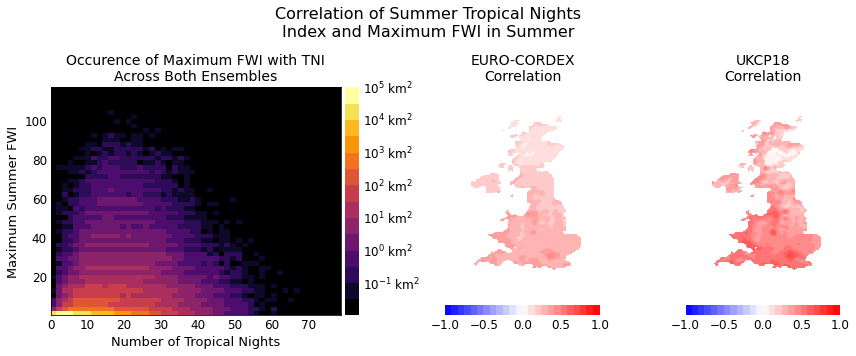

In [12]:
# Number of tropical nights in summer correlation with maximum FWI in summer
fig = plt.figure(figsize=(12, 5),tight_layout=True)

fig.suptitle('Correlation of Summer Tropical Nights\nIndex and Maximum FWI in Summer',fontsize = 16)

widths = [1,0.5,0.5]
heights = [1]
grid = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,height_ratios=heights)

cmap = copy.copy(mpl.cm.get_cmap("inferno"))
cmap.set_bad('k')
levels = np.linspace(-2, 5, 7*2+1)
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
ax_1 = fig.add_subplot(grid[0,0])
ax_1.set_title('Occurence of Maximum FWI with TNI\nAcross Both Ensembles',fontsize=14)
ax_1.set_xlabel('Number of Tropical Nights',fontsize=13)
ax_1.set_ylabel('Maximum Summer FWI',fontsize=13)
ax_1.tick_params(length=0,labelsize=12)
cmap = copy.copy(mpl.cm.get_cmap("inferno"))
cmap.set_bad('k')
image = ax_1.pcolormesh(tni_fwimax_xs,tni_fwimax_ys,np.log10(tni_fwimax),cmap=cmap,norm=norm)
divider = make_axes_locatable(ax_1)
cx = divider.append_axes('right', size='5%', pad=0.05)
cbr = fig.colorbar(image, cax=cx, orientation='vertical',ticks=[-2,-1, 0, 1, 2, 3, 4, 5])
tick_locator = ticker.MaxNLocator(nbins=8)
cbr.locator = tick_locator
cbr.update_ticks()
cbr.outline.set_visible(False)
cbr.ax.tick_params(length=0,labelsize=12)
cbr.ax.set_yticklabels(['','$10^{-1}$ km$^2$', '$10^{0}$ km$^2$','$10^{1}$ km$^2$', 
                         '$10^{2}$ km$^2$','$10^{3}$ km$^2$', 
                         '$10^{4}$ km$^2$','$10^{5}$ km$^2$',])  # vertically oriented colorbar
#cbr.ax.yaxis.set_major_formatter(FormatStrFormatter('$10^{%d}$ km$^2$'))



ax_2 = fig.add_subplot(grid[0,1])
ax_2.set_title('EURO-CORDEX\nCorrelation',fontsize=14)
mapd = (tni_fwi_cor_map)[5:115,20:85]
levels = np.linspace(-1,1, 24+1)
img = ax_2.contourf(mapd,cmap=plt.get_cmap('bwr'),levels=levels)
#ax_2.text(0,100, '(B)', size=14,weight='bold')
ax_2.axis('off')
divider = make_axes_locatable(ax_2)
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb = fig.colorbar(img, cax=cax, orientation='horizontal',ticks=[-1,-0.5,0,0.5,1])
cb.outline.set_visible(False)
cb.ax.tick_params(length=0,labelsize=12)


ax_3 = fig.add_subplot(grid[0,2])
ax_3.set_title('UKCP18\nCorrelation',fontsize=14)
mapd = (tni_fwi_cor_map_uk)[5:115,20:85]
levels = np.linspace(-1,1, 24+1)
img = ax_3.contourf(mapd,cmap=plt.get_cmap('bwr'),levels=levels)
#ax_2.text(0,100, '(B)', size=14,weight='bold')
ax_3.axis('off')
divider = make_axes_locatable(ax_3)
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb = fig.colorbar(img, cax=cax, orientation='horizontal',ticks=[-1,-0.5,0,0.5,1])
cb.outline.set_visible(False)
cb.ax.tick_params(length=0,labelsize=12)


plt.tight_layout()

plt.savefig('/home/theo/final_images/5.images/__TNIxFWI')

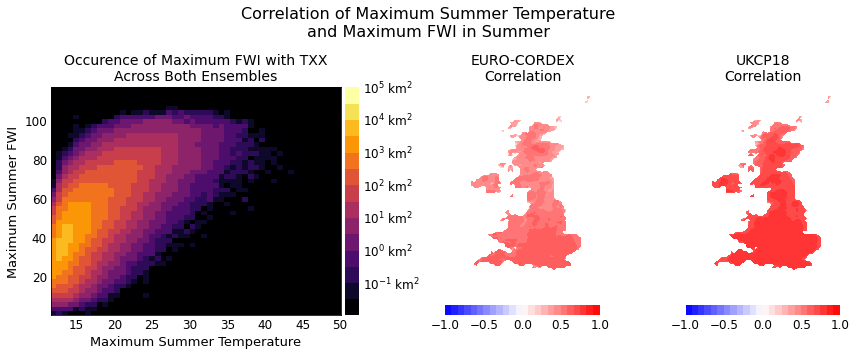

In [13]:
fig = plt.figure(figsize=(12, 5),tight_layout=True)

fig.suptitle('Correlation of Maximum Summer Temperature\nand Maximum FWI in Summer',fontsize = 16)

widths = [1,0.5,0.5]
heights = [1]
grid = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,height_ratios=heights)

ax_3 = fig.add_subplot(grid[0,0])
ax_3.set_title('Occurence of Maximum FWI with TXX\nAcross Both Ensembles',fontsize=14)
ax_3.set_xlabel('Maximum Summer Temperature',fontsize=13)
ax_3.set_ylabel('Maximum Summer FWI',fontsize=13)
ax_3.tick_params(length=0,labelsize=12)
cmap = copy.copy(mpl.cm.get_cmap("inferno"))
cmap.set_bad('k')
image = ax_3.pcolormesh(txx_fwimax_xs,txx_fwimax_ys,np.log10(txx_fwimax),cmap=cmap,norm=norm)
divider = make_axes_locatable(ax_3)
cx = divider.append_axes('right', size='5%', pad=0.05)
cbr = fig.colorbar(image, cax=cx, orientation='vertical',ticks=[-2,-1, 0, 1, 2, 3, 4, 5])
tick_locator = ticker.MaxNLocator(nbins=8)
cbr.locator = tick_locator
cbr.update_ticks()
cbr.outline.set_visible(False)
cbr.ax.tick_params(length=0,labelsize=12)
cbr.ax.set_yticklabels(['','$10^{-1}$ km$^2$', '$10^{0}$ km$^2$','$10^{1}$ km$^2$', 
                         '$10^{2}$ km$^2$','$10^{3}$ km$^2$', 
                         '$10^{4}$ km$^2$','$10^{5}$ km$^2$',])  # vertically oriented colorbar


ax_4 = fig.add_subplot(grid[0,1])
ax_4.set_title('EURO-CORDEX\nCorrelation',fontsize=14)
mapd = (txx_fwi_cor_map)[5:115,20:85]
levels = np.linspace(-1,1, 24+1)
img = ax_4.contourf(mapd,cmap=plt.get_cmap('bwr'),levels=levels)
#ax_2.text(0,100, '(B)', size=14,weight='bold')
ax_4.axis('off')
divider = make_axes_locatable(ax_4)
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb = fig.colorbar(img, cax=cax, orientation='horizontal',ticks=[-1,-0.5,0,0.5,1])
cb.outline.set_visible(False)
cb.ax.tick_params(length=0,labelsize=12)



ax_5 = fig.add_subplot(grid[0,2])
ax_5.set_title('UKCP18\nCorrelation',fontsize=14)
mapd = (txx_fwi_cor_map_uk)[5:115,20:85]
levels = np.linspace(-1,1, 24+1)
img = ax_5.contourf(mapd,cmap=plt.get_cmap('bwr'),levels=levels)
#ax_2.text(0,100, '(B)', size=14,weight='bold')
ax_5.axis('off')
divider = make_axes_locatable(ax_5)
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb = fig.colorbar(img, cax=cax, orientation='horizontal',ticks=[-1,-0.5,0,0.5,1])
cb.outline.set_visible(False)
cb.ax.tick_params(length=0,labelsize=12)

plt.tight_layout()

plt.savefig('/home/theo/final_images/5.images/__TXXxFWI')

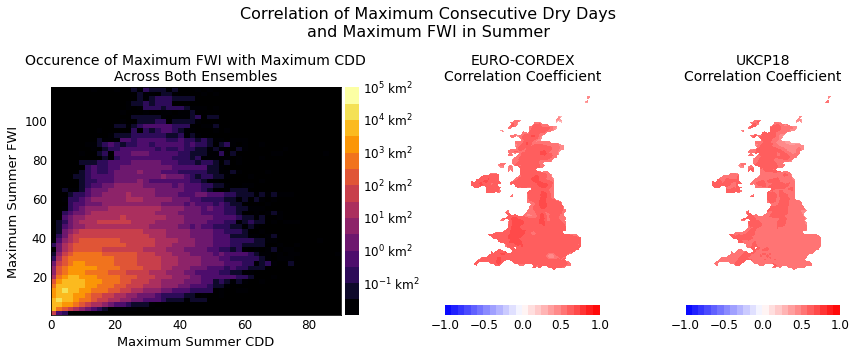

In [14]:
# Maximum number of consecutive dry days in summer (i.e. rain less than 1mm)

fig = plt.figure(figsize=(12, 5),tight_layout=True)

fig.suptitle('Correlation of Maximum Consecutive Dry Days\nand Maximum FWI in Summer',fontsize = 16)

widths = [1,0.5,0.5]
heights = [1]
grid = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,height_ratios=heights)

ax_3 = fig.add_subplot(grid[0,0])
ax_3.set_title('Occurence of Maximum FWI with Maximum CDD\nAcross Both Ensembles',fontsize=14)
ax_3.set_xlabel('Maximum Summer CDD',fontsize=13)
ax_3.set_ylabel('Maximum Summer FWI',fontsize=13)
ax_3.tick_params(length=0,labelsize=12)
cmap = copy.copy(mpl.cm.get_cmap("inferno"))
cmap.set_bad('k')
image = ax_3.pcolormesh(cdd_fwimax_xs,cdd_fwimax_ys,np.log10(cdd_fwimax),cmap=cmap,norm=norm)
divider = make_axes_locatable(ax_3)
cx = divider.append_axes('right', size='5%', pad=0.05)
cbr = fig.colorbar(image, cax=cx, orientation='vertical',ticks=[-2,-1, 0, 1, 2, 3, 4, 5])
tick_locator = ticker.MaxNLocator(nbins=8)
cbr.locator = tick_locator
cbr.update_ticks()
cbr.outline.set_visible(False)
cbr.ax.tick_params(length=0,labelsize=12)
cbr.ax.set_yticklabels(['','$10^{-1}$ km$^2$', '$10^{0}$ km$^2$','$10^{1}$ km$^2$', 
                         '$10^{2}$ km$^2$','$10^{3}$ km$^2$', 
                         '$10^{4}$ km$^2$','$10^{5}$ km$^2$',])  # vertically oriented colorbar


ax_4 = fig.add_subplot(grid[0,1])
ax_4.set_title('EURO-CORDEX\nCorrelation Coefficient',fontsize=14)
mapd = (cdd_fwi_cor_map)[5:115,20:85]
levels = np.linspace(-1,1, 24+1)
img = ax_4.contourf(mapd,cmap=plt.get_cmap('bwr'),levels=levels)
#ax_2.text(0,100, '(B)', size=14,weight='bold')
ax_4.axis('off')
divider = make_axes_locatable(ax_4)
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb = fig.colorbar(img, cax=cax, orientation='horizontal',ticks=[-1,-0.5,0,0.5,1])
cb.outline.set_visible(False)
cb.ax.tick_params(length=0,labelsize=12)



ax_5 = fig.add_subplot(grid[0,2])
ax_5.set_title('UKCP18\nCorrelation Coefficient',fontsize=14)
mapd = (cdd_fwi_cor_map_uk)[5:115,20:85]
levels = np.linspace(-1,1, 24+1)
img = ax_5.contourf(mapd,cmap=plt.get_cmap('bwr'),levels=levels)
#ax_2.text(0,100, '(B)', size=14,weight='bold')
ax_5.axis('off')
divider = make_axes_locatable(ax_5)
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb = fig.colorbar(img, cax=cax, orientation='horizontal',ticks=[-1,-0.5,0,0.5,1])
cb.outline.set_visible(False)
cb.ax.tick_params(length=0,labelsize=12)

plt.tight_layout()

plt.savefig('/home/theo/final_images/5.images/__CDDxFWI')